In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据并清理'天气'列
file_path = 'nanjing_weather_last_3_months.csv'
weather_data = pd.read_csv(file_path)
weather_data['天气'] = weather_data['天气'].str.replace(r'\r\n\s+', ' / ', regex=True)
weather_data['天气'] = weather_data['天气'].str.replace(r' / /', ' / ', regex=True)
weather_data.head()


,最高气温,最低气温,天气,风向,日期,星期,风力,平均气温
0,35,28,多云 / 多云,东风,2024年09月01日,Sunday,3,31
1,34,26,雷阵雨 / 阴,东北风,2024年09月02日,Monday,4,30
2,33,25,多云 / 多云,东北风,2024年09月03日,Tuesday,3,29
3,34,26,多云 / 晴,东南风,2024年09月04日,Wednesday,3,30
4,35,26,晴 / 晴,东北风,2024年09月05日,Thursday,3,30


In [21]:
weather_data.describe()

,最高气温,最低气温,风力,平均气温
count,88.000000,88.000000,88.000000,88.000000
mean,33.477273,26.431818,3.761364,29.727273
std,3.823633,2.867958,0.909646,3.233187
min,24.000000,16.000000,3.000000,20.000000
25%,31.000000,26.000000,3.000000,28.750000
50%,34.000000,27.000000,4.000000,30.000000
75%,36.000000,28.000000,4.000000,32.000000
max,40.000000,31.000000,7.000000,35.000000


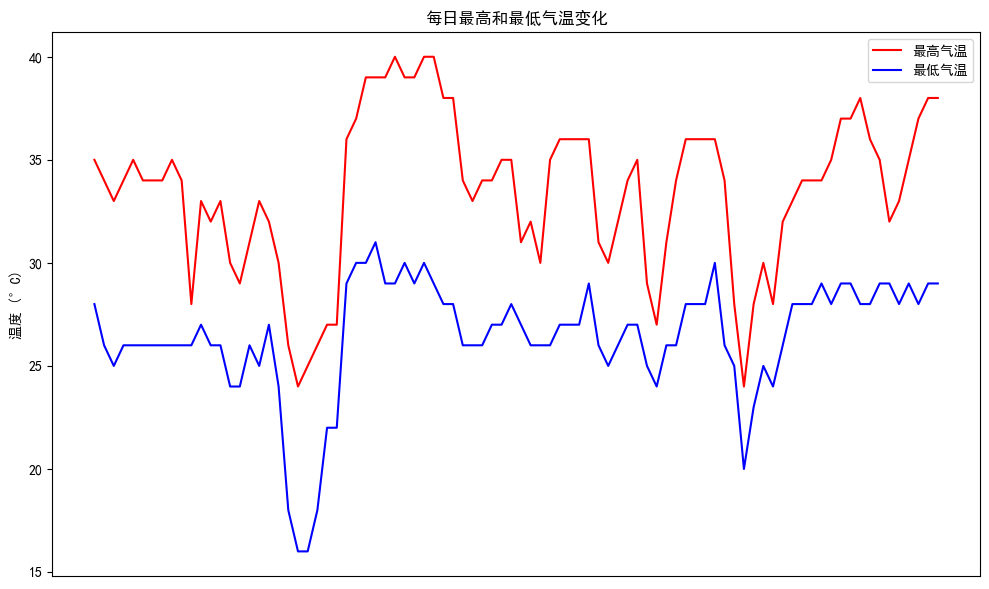

In [22]:
# 气温变化图
plt.figure(figsize=(10, 6))
plt.plot(weather_data['最高气温'], label='最高气温', color='red')
plt.plot(weather_data['最低气温'], label='最低气温', color='blue')
plt.xlabel('')  # 去掉X轴标签
plt.xticks([])  # 去掉X轴刻度
plt.ylabel('温度 (°C)')
plt.title('每日最高和最低气温变化')
plt.legend()
plt.tight_layout()
plt.show()

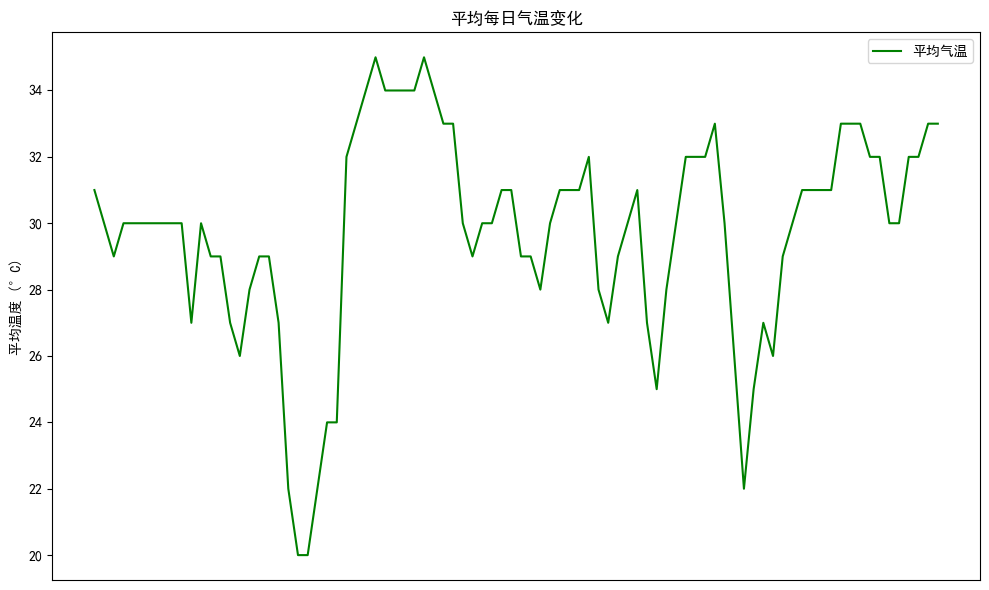

In [23]:
# 每日气温图
plt.figure(figsize=(10, 6))
plt.plot(weather_data['平均气温'], label='平均气温', color='green')
plt.xlabel('')  
plt.xticks([])  
plt.ylabel('平均温度 (°C)')
plt.title('平均每日气温变化')
plt.legend()
plt.tight_layout()
plt.show()

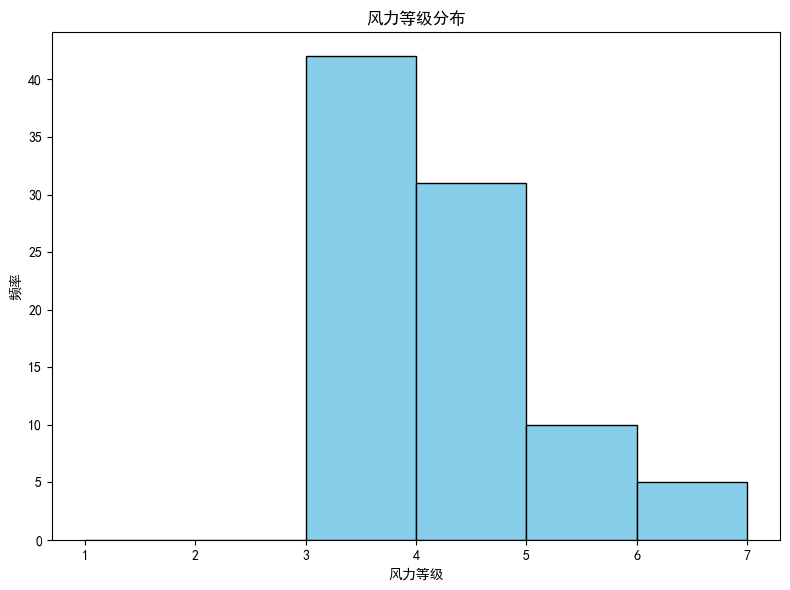

In [24]:
# 风力分布直方图
plt.figure(figsize=(8, 6))
plt.hist(weather_data['风力'], bins=range(1, weather_data['风力'].max() + 1), color='skyblue', edgecolor='black')
plt.xlabel('风力等级')
plt.ylabel('频率')
plt.title('风力等级分布')
plt.tight_layout()
plt.show()

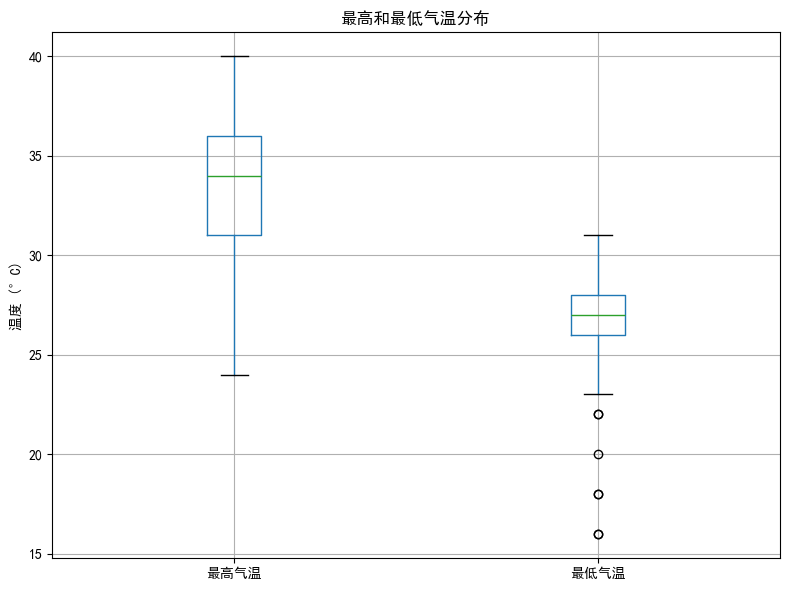

In [25]:
# 最高和最低气温箱线图
plt.figure(figsize=(8, 6))
weather_data[['最高气温', '最低气温']].boxplot()
plt.title('最高和最低气温分布')
plt.ylabel('温度 (°C)')
plt.tight_layout()
plt.show()

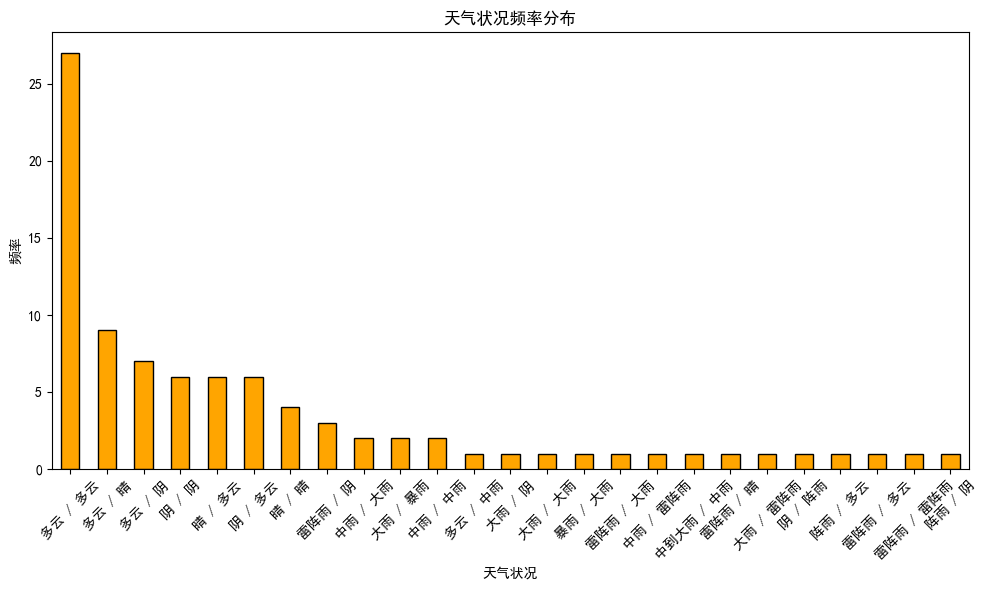

In [31]:
# 天气状况频率图
weather_counts = weather_data['天气'].value_counts()
plt.figure(figsize=(10, 6))
weather_counts.plot(kind='bar', color='orange', edgecolor='black')
plt.title('天气状况频率分布')
plt.xlabel('天气状况')
plt.ylabel('频率')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


weather_data = pd.read_csv('nanjing_weather_last_3_months.csv')


weather_data['天气'] = weather_data['天气'].str.replace(r'\r\n\s+', ' / ', regex=True)
weather_data['天气'] = weather_data['天气'].str.replace(r' / /', ' / ', regex=True)

# 使用LabelEncoder将天气列和风向列进行编码
label_encoder_weather = LabelEncoder()
label_encoder_wind = LabelEncoder()
weather_data['天气编码'] = label_encoder_weather.fit_transform(weather_data['天气'])
weather_data['风向编码'] = label_encoder_wind.fit_transform(weather_data['风向'])

#StandardScaler进行标准化
scaler = StandardScaler()
scaled_features = scaler.fit_transform(weather_data[['最高气温', '最低气温', '天气编码', '风向编码', '风力', '平均气温']])
scaled_data = pd.DataFrame(scaled_features, columns=['最高气温', '最低气温', '天气编码', '风向编码', '风力', '平均气温'])

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i+seq_length].values
        y = data.iloc[i+seq_length][['风力', '平均气温']].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 时间序列长度
seq_length = 7
X, y = create_sequences(scaled_data, seq_length)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class ImprovedLSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=2, dropout=0.2):
        super(ImprovedLSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        predictions = self.linear(lstm_out)
        return predictions


input_size = 6  # 特征数量
hidden_layer_size = 64
output_size = 2  # 预测风力和平均气温

model = ImprovedLSTMModel(input_size, hidden_layer_size, output_size)

# 损失函数和优化器
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
best_val_loss = float('inf')
patience = 10
no_improve = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for seq, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for seq, labels in val_loader:
            y_pred = model(seq)
            val_loss += loss_function(y_pred, labels).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    print(f'Epoch {epoch+1} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        no_improve = 0
    else:
        no_improve += 1
    
    if no_improve >= patience:
        print("Early stopping!")
        break


model.load_state_dict(torch.load('best_model.pth'))

# 预测
def predict_future(model, last_sequence, scaler, days_to_predict=31):
    model.eval()
    predictions = []
    current_seq = last_sequence.copy()

    for _ in range(days_to_predict):
        with torch.no_grad():
            input_tensor = torch.tensor(current_seq[-seq_length:], dtype=torch.float32).unsqueeze(0)
            pred = model(input_tensor).squeeze().numpy()
            predictions.append(pred)

            # 更新序列
            new_day = np.zeros(input_size)
            new_day[4:6] = pred  # 只更新风力和平均气温
            current_seq = np.vstack([current_seq, new_day])

    predictions = np.array(predictions)
    # 只反归一化风力和平均气温
    predictions_unscaled = np.zeros_like(predictions)
    predictions_unscaled[:, 0] = predictions[:, 0] * scaler.scale_[4] + scaler.mean_[4]  # 风力
    predictions_unscaled[:, 1] = predictions[:, 1] * scaler.scale_[5] + scaler.mean_[5]  # 平均气温
    
    # 对风力进行四舍五入
    predictions_unscaled[:, 0] = np.round(predictions_unscaled[:, 0])
    
    return predictions_unscaled


last_seq = scaled_data.iloc[-seq_length:].values
future_predictions = predict_future(model, last_seq, scaler)

future_dates = pd.date_range(start="2024-10-01", periods=31, freq='D')
predicted_weather = pd.DataFrame(future_predictions, columns=['预测风力', '预测平均气温'])
predicted_weather['日期'] = future_dates

output_file = 'predicted_weather_october_improved.csv'
predicted_weather.to_csv(output_file, index=False)

print(f'改进后的预测结果已保存到 {output_file}')

# 计算训练集的MSE
model.eval()
train_predictions = []
train_actual = []
with torch.no_grad():
    for seq, labels in train_loader:
        pred = model(seq)
        train_predictions.extend(pred.numpy())
        train_actual.extend(labels.numpy())

train_predictions = np.array(train_predictions)
train_actual = np.array(train_actual)

# 反归一化预测值和实际值
train_predictions_unscaled = np.zeros_like(train_predictions)
train_actual_unscaled = np.zeros_like(train_actual)

for i in range(2):  # 0: 风力, 1: 平均气温
    train_predictions_unscaled[:, i] = train_predictions[:, i] * scaler.scale_[i+4] + scaler.mean_[i+4]
    train_actual_unscaled[:, i] = train_actual[:, i] * scaler.scale_[i+4] + scaler.mean_[i+4]

mse_wind = mean_squared_error(train_actual_unscaled[:, 0], train_predictions_unscaled[:, 0])
mse_temp = mean_squared_error(train_actual_unscaled[:, 1], train_predictions_unscaled[:, 1])
print(f"训练集上的风力MSE: {mse_wind:.4f}")
print(f"训练集上的平均气温MSE: {mse_temp:.4f}")


plt.figure(figsize=(12, 10))


plt.subplot(2, 1, 1)
plt.plot(future_dates, predicted_weather['预测风力'], marker='o')
plt.title('10月风力预测')
plt.xlabel('日期')
plt.ylabel('风力')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(future_dates, predicted_weather['预测平均气温'], marker='o', color='r')
plt.title('10月平均气温预测')
plt.xlabel('日期')
plt.ylabel('平均气温 (°C)')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.savefig('october_weather_prediction.png')
plt.close()

# 热力图可视化
plt.figure(figsize=(12, 8))
sns.heatmap(predicted_weather[['预测风力', '预测平均气温']].T, 
            annot=True, 
            fmt='.1f', 
            cmap='YlOrRd', 
            yticklabels=['风力', '平均气温'],
            xticklabels=future_dates.strftime('%m-%d'))
plt.title('10月天气预测热力图')
plt.tight_layout()
plt.savefig('october_weather_heatmap.png')
plt.close()

Epoch 1 Train Loss: 1.1665 Val Loss: 0.6864
Epoch 2 Train Loss: 1.1531 Val Loss: 0.6775
Epoch 3 Train Loss: 1.1439 Val Loss: 0.6688
Epoch 4 Train Loss: 1.1353 Val Loss: 0.6602
Epoch 5 Train Loss: 1.1303 Val Loss: 0.6513
Epoch 6 Train Loss: 1.1175 Val Loss: 0.6409
Epoch 7 Train Loss: 1.1039 Val Loss: 0.6302
Epoch 8 Train Loss: 1.0926 Val Loss: 0.6171
Epoch 9 Train Loss: 1.0771 Val Loss: 0.6035
Epoch 10 Train Loss: 1.0669 Val Loss: 0.5890
Epoch 11 Train Loss: 1.0519 Val Loss: 0.5731
Epoch 12 Train Loss: 1.0365 Val Loss: 0.5569
Epoch 13 Train Loss: 0.9976 Val Loss: 0.5408
Epoch 14 Train Loss: 1.0023 Val Loss: 0.5229
Epoch 15 Train Loss: 0.9630 Val Loss: 0.5069
Epoch 16 Train Loss: 0.9500 Val Loss: 0.4927
Epoch 17 Train Loss: 0.9273 Val Loss: 0.4810
Epoch 18 Train Loss: 0.9062 Val Loss: 0.4703
Epoch 19 Train Loss: 0.8963 Val Loss: 0.4617
Epoch 20 Train Loss: 0.8529 Val Loss: 0.4521
Epoch 21 Train Loss: 0.8520 Val Loss: 0.4440
Epoch 22 Train Loss: 0.8095 Val Loss: 0.4349
Epoch 23 Train Loss

In [33]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取天气数据
weather_data = pd.read_csv('nanjing_weather_last_3_months.csv')

# 清洗天气数据
weather_data['天气'] = weather_data['天气'].str.replace(r'\r\n\s+', ' / ', regex=True)  # 替换换行符和多余空格
weather_data['天气'] = weather_data['天气'].str.replace(r' / /', ' / ', regex=True)  # 替换多重分隔符

# 使用LabelEncoder将天气和风向列进行编码
label_encoder_weather = LabelEncoder()
label_encoder_wind = LabelEncoder()
weather_data['天气编码'] = label_encoder_weather.fit_transform(weather_data['天气'])
weather_data['风向编码'] = label_encoder_wind.fit_transform(weather_data['风向'])

# 标准化特征数据
scaler = StandardScaler()
scaled_features = scaler.fit_transform(weather_data[['最高气温', '最低气温', '天气编码', '风向编码', '风力', '平均气温']])
scaled_data = pd.DataFrame(scaled_features, columns=['最高气温', '最低气温', '天气编码', '风向编码', '风力', '平均气温'])

# 创建时间序列数据
def create_sequences(data, seq_length):
    xs, ys = [], []  # 存储特征和标签
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i + seq_length].values  # 取出序列
        y = data.iloc[i + seq_length][['风力', '平均气温']].values  # 取出标签
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 设置时间序列长度
seq_length = 7
X, y = create_sequences(scaled_data, seq_length)

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建数据集和数据加载器
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 定义改进的LSTM模型
class ImprovedLSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=2, dropout=0.2):
        super(ImprovedLSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        # LSTM层
        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = torch.nn.Dropout(dropout)  # Dropout层以防止过拟合
        self.linear = torch.nn.Linear(hidden_layer_size, output_size)  # 输出层

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)  # 进行前向传播
        lstm_out = self.dropout(lstm_out[:, -1, :])  # 取最后一个时间步的输出
        predictions = self.linear(lstm_out)  # 经过线性层得到预测值
        return predictions

# 初始化模型参数
input_size = 6  # 特征数量
hidden_layer_size = 64  # 隐藏层单元数量
output_size = 2  # 预测风力和平均气温

model = ImprovedLSTMModel(input_size, hidden_layer_size, output_size)

# 定义损失函数和优化器
loss_function = torch.nn.MSELoss()  # 均方误差损失
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam优化器

# 训练模型
epochs = 100
best_val_loss = float('inf')
patience = 10  # 提前停止的耐心值
no_improve = 0  # 没有改进的次数

for epoch in range(epochs):
    model.train()  # 设置模型为训练模式
    train_loss = 0
    for seq, labels in train_loader:
        optimizer.zero_grad()  # 清空梯度
        y_pred = model(seq)  # 模型预测
        loss = loss_function(y_pred, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
        train_loss += loss.item()
    
    model.eval()  # 设置模型为评估模式
    val_loss = 0
    with torch.no_grad():
        for seq, labels in val_loader:
            y_pred = model(seq)
            val_loss += loss_function(y_pred, labels).item()
    
    train_loss /= len(train_loader)  # 平均训练损失
    val_loss /= len(val_loader)  # 平均验证损失
    
    print(f'Epoch {epoch+1} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}')
    
    # 检查是否有改进
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')  # 保存最佳模型
        no_improve = 0
    else:
        no_improve += 1
    
    # 如果没有改进，提前停止
    if no_improve >= patience:
        print("Early stopping!")
        break

# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth'))

# 预测未来的天气
def predict_future(model, last_sequence, scaler, days_to_predict=31):
    model.eval()
    predictions = []
    current_seq = last_sequence.copy()

    for _ in range(days_to_predict):
        with torch.no_grad():
            input_tensor = torch.tensor(current_seq[-seq_length:], dtype=torch.float32).unsqueeze(0)  # 生成输入张量
            pred = model(input_tensor).squeeze().numpy()  # 模型预测
            predictions.append(pred)

            # 更新序列
            new_day = np.zeros(input_size)
            new_day[4:6] = pred  # 只更新风力和平均气温
            current_seq = np.vstack([current_seq, new_day])  # 将新的一天加入序列

    predictions = np.array(predictions)
    # 反归一化风力和平均气温
    predictions_unscaled = np.zeros_like(predictions)
    predictions_unscaled[:, 0] = predictions[:, 0] * scaler.scale_[4] + scaler.mean_[4]  # 风力
    predictions_unscaled[:, 1] = predictions[:, 1] * scaler.scale_[5] + scaler.mean_[5]  # 平均气温
    
    # 对风力进行四舍五入
    predictions_unscaled[:, 0] = np.round(predictions_unscaled[:, 0])
    
    return predictions_unscaled

# 获取最后的序列并进行预测
last_seq = scaled_data.iloc[-seq_length:].values
future_predictions = predict_future(model, last_seq, scaler)

# 生成未来日期
future_dates = pd.date_range(start="2024-10-01", periods=31, freq='D')
predicted_weather = pd.DataFrame(future_predictions, columns=['预测风力', '预测平均气温'])
predicted_weather['日期'] = future_dates

# 保存预测结果到CSV文件
output_file = 'predicted_weather_october_improved.csv'
predicted_weather.to_csv(output_file, index=False)

print(f'改进后的预测结果已保存到 {output_file}')

# 计算训练集的均方误差
model.eval()
train_predictions = []
train_actual = []
with torch.no_grad():
    for seq, labels in train_loader:
        pred = model(seq)
        train_predictions.extend(pred.numpy())
        train_actual.extend(labels.numpy())

train_predictions = np.array(train_predictions)
train_actual = np.array(train_actual)

# 反归一化预测值和实际值
train_predictions_unscaled = np.zeros_like(train_predictions)
train_actual_unscaled = np.zeros_like(train_actual)

for i in range(2):  # 0: 风力, 1: 平均气温
    train_predictions_unscaled[:, i] = train_predictions[:, i] * scaler.scale_[i + 4] + scaler.mean_[i + 4]
    train_actual_unscaled[:, i] = train_actual[:, i] * scaler.scale_[i + 4] + scaler.mean_[i + 4]

# 计算均方误差
mse_wind = mean_squared_error(train_actual_unscaled[:, 0], train_predictions_unscaled[:, 0])  # 风力MSE
mse_temp = mean_squared_error(train_actual_unscaled[:, 1], train_predictions_unscaled[:, 


SyntaxError: incomplete input (721562122.py, line 190)